# Selección de clientes con Active Federated Learning - Método basado en rendimiento del modelo

En este notebook vamos a utilizar nuestro modelo de entrenamiento en Aprendizaje Federado utilizando AFL como algoritmo de selección de clientes [1] sobre el dataset de MNIST, que es un conjunto de imágenes de dígitos manuscritos del 0 al 9 [2]. Se trata de un problema de visión por computador al que usaremos para comparar el rendimiento del método de selección AFL frente al convencional.

> [1] https://arxiv.org/abs/1909.12641.
>
> [2] http://yann.lecun.com/exdb/mnist.

In [ ]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is not installed.
Installing dependency flexible-fl...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 653.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
  Created wheel for cardinality: filename=cardinality-0.1.1-py3-none-any.whl size=2587 sha256=92108ffc8384e95587d46a0e4875727e623e4b0da800a101f7e529f5c17c530e
  Stored in directory: /root/.cache/pip/wheels/b8/19/d1/2665c004b583a7d1880fa59055a3e462d6e35841a01b57010b
Successfully built cardinality


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cpu'

# Cargar datasets - MNIST, CIFAR-10

Cargaremos $2$ de los datasets que usaremos para entrenar el modelo de ML.

## MNIST
El primero será MNIST (Modified National Institute of Standards and Technology database), que consiste en imágenes de $28$ pixeles de ancho y alto en escala de grises de dígitos manuscritos del $0$ al $9$. Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{28\times 28}, x_i \in \{1, ..., 255\}$, donde $x_i$ es un pixel de la imagen $X$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ que representa el dígito al que corresponde la imagen. El conjunto de entrenamiento consta de $N=240,000$ imágenes.

El dataset descargado será el de _Extended MNIST_ [1], que comprende una versión extendida del concepto original de MNIST para proporcionar dígitos y letras manuscritas, una cantidad más grande de datos, diferentes formas de separar los datos (solo dígitos, letras, por clase, ...), etc. Nosotros solo utilizaremos los dígitos para entrenar el clásico MNIST, del cual su versión extendida consta de $N = 280,000$ imágenes de dígitos manuscritos.

Una característica importante de EMNIST es que cada imagen tendrá asociado un autor (i.e. la persona que ha escrito el dígito o letra), tal que un dígito es escrito por un solo autor pero un autor puede escribir muchos dígitos. Esto nos da la ventaja de poder distribuir los datos de forma No-IID tal que cada cliente tendrá los datos con autoría de un solo autor.

FLEX nos da utilidades para cargar EMNIST y federarlo automáticamente con la función `load`, donde además descargamos el dataset de test y solo usaremos el dataset de dígitos clásico de MNIST. Definimos también las transformaciones a realizar a los datos que son simplemente normalizar cada pixel a valores de $[0,1]$ (función `ToTensor()`) y normalizar los valores de cada pixel con una media y desviación estándar de $0.5$.

> [1] https://www.nist.gov/itl/products-and-services/emnist-dataset

In [ ]:
from flex.datasets import load
from torchvision import transforms

flex_dataset_mnist, test_data = load("federated_emnist", return_test=True, split="digits")

# Assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = test_data

# apply transforms
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

[sultan]: md5 -q ./emnist-digits.mat;
DEBUG:sultan:md5 -q ./emnist-digits.mat;
[sultan]: Unable to run 'md5 -q ./emnist-digits.mat;'
CRITICAL:sultan:Unable to run 'md5 -q ./emnist-digits.mat;'
[sultan]: --{ TRACEBACK }----------------------------------------------------------------------------------------------------
CRITICAL:sultan:--{ TRACEBACK }----------------------------------------------------------------------------------------------------
[sultan]: | NoneType: None
CRITICAL:sultan:| NoneType: None
[sultan]: | 
CRITICAL:sultan:| 
[sultan]: -------------------------------------------------------------------------------------------------------------------
CRITICAL:sultan:-------------------------------------------------------------------------------------------------------------------
[sultan]: --{ STDERR }-------------------------------------------------------------------------------------------------------
CRITICAL:sultan:--{ STDERR }---------------------------------------------

## CIFAR-10

El segundo dataset es CIFAR-10 (_Canadian Institute for Advanced Research_)[1], el cual es otro de los datasets junto con MNIST, más utilizados en el campo del Deep Learning y Visión por Computador. CIFAR-10 consiste en una colección de imágenes de $32$ pixeles de altura y de ancho a color ($3$ canales RGB) representando $10$ objetos reales:
- Avión (airplane)
- Automóvil (automobile)
- Pájaro (bird)
- Gato (cat)
- Ciervo (deer)
- Perro (dog)
- Rana (frog)
- Caballo (horse)
- Barco (ship)
- Camión (truck)

Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{32\times 32 \times 3}, x_i \in \{1, ..., 255\}$, donde $x_i^c$ es un pixel de la imagen $X$ en el canal $c$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ tal que indexa la lista de clases $C=(c_0=\text{plane}, c_1=\text{automobile}, ..., c_9=\text{truck})$. El conjunto de entrenamiento consta de $N=50,000$ datos de entrada.

A diferencia de EMNIST, FLEX no carga por defecto CIFAR-10, por lo que deberemos de descargar y federar manualmente el dataset. Utilizaremos el dataset descargado desde `torchvision` de PyTorch y federamos utilizando una configuración por defecto de FLEX con un número de nodos o clientes de $K = 100$ clientes. Definimos también las transformaciones para escalar los valores a $[0,1]$ y normalizar con medias y desviaciones estándar específicas de CIFAR-10 [2].

> [1] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [2] https://github.com/kuangliu/pytorch-cifar/issues/19

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from flex.data import FedDataDistribution, FedDatasetConfig, Dataset

train_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=None,  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=None,  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = 100

# create Federated data distribution of CIFAR-10
flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=train_data,
    config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalizar con las medias y desviaciones estándar específicas de CIFAR-10
])

100%|██████████| 170498071/170498071 [00:02<00:00, 77023772.01it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


# Modelos de aprendizaje

Definimos dos modelos de Machine Learning, uno para cada uno de los dos datasets que hemos definido anteriormente. Para ambos problemas, usaremos como función de pérdida o _criterion_ la función de entropía cruzada o _Cross Entropy Loss_ cuya definición [1] la define como (para una muestra $n$):

$$l_n = -w_{y_n} \cdot \log \frac{\exp (x_n, y_n)}{\sum_{c=0}^C \exp (x_n, c)} =-w_{y_n}\cdot \log (\text{Softmax} (x_n, y_n))$$

En ambos problemas utilizaremos Adam [2] como optimizador o algoritmo de aprendizaje. Utilizaremos los mismos parámetros que en [2] al haber hecho los experimentos sobre modelos similares y con los mismos datasets que estamos usando y que han demostrando buenos resultados: $\eta = 0.01$ y $\beta_1 = 0.9,\beta_2 = 0.999$. Estos parámetros están definidos por defecto en la librería de PyTorch [3].

> [1] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
>
> [2] https://arxiv.org/abs/1412.6980
>
> [3] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

---




## Perceptrón Multicapa (MNIST)

El primero, que lo usaremos para ajustar MNIST, será un Perceptrón Multicapa (MLP) de dos capas ocultas de $128$ parámetros la primera y $10$ la segunda (correspondiente al número de clases), y usando ReLU [1] como función de activación.

El modelo inicialmente lo tendrá el servidor y será copiado a cada uno de los clientes. En FLEX usamos el decorador `@init_model_server` para inicializar el modelo en el servidor, donde también podemos además de nuestra arquitectura del modelo, el optimizador y la función de pérdida a usar.

> [1] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [ ]:
from typing import Tuple

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron classifier with two hidden layers.
    """
    def __init__(self, in_features: Tuple[int, int], hidden_features: int, num_classes: int = 10):
        super().__init__()

        width, height = in_features

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

Teniendo el dataset MNIST federado y la arquitectura y modelo definidos, podemos crear una `pool` de FLEX que podremos utilizar para entrenar el modelo con aprendizaje federado.

In [ ]:
flex_pool = FlexPool.client_server_pool(
    flex_dataset_mnist, server_id=server_id, init_func=build_server_model_mlp
)

clients = flex_pool.clients
servers = flex_pool.servers
aggregators = flex_pool.aggregators

print(
    f"Number of nodes in the pool {len(flex_pool)}: {len(servers)} server plus {len(clients)} clients. The server is also an aggregator"
)

Podemos ver que al final tendremos $3579$ clientes y un servidor, esto debido a que utilizaremos el escenario cliente-servidor convencional y típico en problemas de aprendizaje federado, por lo que el servidor tendrá de roles _agregador_ y _servidor_, y los $3579$ clientes corresponden a la cantidad de autores que han contribuido a crear el conjunto de datos EMNIST para dígitos.

---

## Red Neuronal Convolucional (CNN) - CIFAR-10

Para nuestro segundo problema, que consta de ajustar un modelo para clasificar CIFAR-10, utilizaremos un red neuronal convolucional o CNN. A diferencia de MNIST, CIFAR-10 tiene unos datos de entrada con una dimensionalidad más compleja, por lo que utilizar una CNN reduciría la cantidad de parámetros necesarios a entrenar.

Concretamente, la arquitectura de la red a implementar será la de una CNN estándar que comprende seis capas convolucionales (CONV) $3\times 3$:
- Pares de $32$, $64$ y $128$ canales consecutivos.
- Cada uno de ellos activados por ReLU y usando _Batch normalization_ (batchnorm).
- Y aplicando _Max Pooling_ $2\times 2$ cada dos capas convolucionales para reducir la dimensionalidad los mapas de activación.

Seguido de $3$ capas _Fully-Connected_ de $382$ y $192$ unidades activadas por ReLU para las capas ocultas y de $10$ unidades activada por Softmax para la capa de salida.

In [ ]:
class CNN(nn.Module):
    """
    Convolucional Neural Net classifier for CIFAR-10 image recognition (32x32 images).
    """
    def __init__(self, in_channels: int = 3, num_classes: int = 10):
        super(CNN, self).__init__()

        # Conv layers
        self.bn1 = nn.BatchNorm2d(32)

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn3 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # FC layers
        self.flatten = nn.Flatten()

        hidden_dims = [382, 192]
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=hidden_dims[0])
        self.fc2 = nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1])
        self.fc3 = nn.Linear(in_features=hidden_dims[1], out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn1(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.bn3(self.conv6(x)))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

## Configuración básica de escenario de FL

Configuraremos un escenario de aprendizaje federado centralizado (CFL) usando la librería FLEXible. FLEXible [1], o simplemente FLEX, es una librería de Python que proporciona un framework para la construcción de entornos de aprendizaje federado para fines de investigación y simulación. FLEX pretende dar flexibilidad en cuanto la gran variedad de escenarios y necesidades que se pueden llegar a plantear para experimentar en entornos federados.

Uno de nuestros objetivos es _integrar_ un método o técnica de selección de clientes en un escenario inicial de FL. La flexibilidad de FLEX nos permitirá conseguir este objetivo gracias a su flujo de mensajes entre entidades separadas por roles, y por la arquitectura modular de estas que nos permiten almacenar información de manera conveniente [1].

> [1] https://arxiv.org/abs/2404.06127
---

### Inicialización del modelo del servidor

El primer paso de nuestro bucle de entrenamiento en aprendizaje federado es inicializar el modelo FLEX del servidor (que posteriormente se distribuirá a los clientes).

Con FLEX podemos hacer uso del decorador `init_server_model` para facilitarnos esta tarea. Esta función entonces debe de instanciar y devolver un modelo de FLEX en donde además definimos el modelo de aprendizaje$^1$, la función de pérdida, el optimizador y cualquier otra información que se usará en las demás fases de la ronda de entrenamiento.

Definimos dos funciones que realizan esta tarea, dos para cada una de nuestras arquitecturas, el Perceptrón Multicapa y la Red Neuronal Convolucional. Como habíamos especificado en el planteamiento del problema de ML a resolver, utilizaremos el optimizador SGD-Adam con sus parámetros por defecto, y la Cross-Entropy como función de pérdida.

> $^1$ No se debe confundir el modelo de tipo `FlexModel` con un modelo de ML. El primero implementa el bloque fundamental que define una entidad en el escenario de FL (donde almacenamos información, sus datos locales, su modelo de aprendizaje, ...). El segundo es un modelo aprendizaje como lo puede ser un módulo de PyTorch o Tensorflow que realiza el aprendizaje automático y la predicción sobre los datos. Se dejará claro la diferencia entre los dos tipos de modelos.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

mnist_in_features = (28, 28)
mnist_hidden_features = 128

@init_server_model
def build_server_model_mlp():
    server_flex_model = FlexModel()

    server_flex_model["model"] = MLP(mnist_in_features, mnist_hidden_features)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

cifar_in_channels = 3
cifar_num_classes = 10

@init_server_model
def build_server_model_cnn():
    server_flex_model = FlexModel()

    server_flex_model["model"] = CNN(cifar_in_channels, cifar_num_classes)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

Number of nodes in the pool 3580: 1 server plus 3579 clients. The server is also an aggregator


---
### Distribuir modelo del servidor

El siguiente paso a realizar en un flujo de entrenamiento de aprendizaje federado es la distribución del modelo del servidor a los cientes. Con FLEX, podemos utilizar el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes, definiendo una función que devuelva el modelo a almacenar en cada cliente.

En este caso, realizamos una copia profunda del modelo del servidor que será asignado a cada cliente.


In [ ]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    return copy.deepcopy(server_flex_model)

### Actualización del modelo del lado del cliente

Definimos la función encargada de realizar el entrenamiento del modelo sobre los datos locales del cliente. A esta función, es conveniente pasarle como parámetros los hiperparámetros de entrenamiento de un modelo de ML convencional como el número de épocas $E$ y el tamaño de _batch_ $B$

In [ ]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse kwargs
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20

    # get client data as a torchvision object
    train_dataset = client_data.to_torchvision_dataset(transform=mnist_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    # get model
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    # train model
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


### Obtener los parámetros de los clientes

Ahora implementamos la función que hace que el servidor (con rol de agregador) recupere los nuevos parámetros actualizados de los clientes. Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [ ]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]

### Agregación de los parámetros

El servidor/agregador agrega entonces estos nuevos parámetros para conseguir el nuevo modelo global. Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos de manera uniforme, conocido como agregador FedAvg [1], donde realizamos la media por columnas para cada capa de pesos.

> [1] https://arxiv.org/abs/1602.05629

In [ ]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [ ]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)


aggregators.map(set_agreggated_weights_to_server, servers)

### Evaluación del modelo global

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [ ]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc


metrics = servers.map(evaluate_global_model)
print("Loss (test):", metrics[0][0])
print("Accuracy (test):", metrics[0][1])

Loss (test): 1.492006006514191
Accuracy (test): 0.675525


### Training loop

A continuación se muestra el bucle de entrenamiento aplicando todas las fases que hemos implementado anteriormente. En esta versión básica se implementa una selección aleatoria, similar a la propuesta en [1] donde se selecciona de manera aleatoria y uniforme $M$ clientes para la ronda actual. Este proceso se repite de forma iterativa un número determinado de rondas.

In [ ]:
def train_n_rounds(n_rounds, clients_per_round=20):
    pool = FlexPool.client_server_pool(
        fed_dataset=flex_dataset, server_id=server_id, init_func=build_server_model
    )
    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies


Running round: 1 of 15
Selected clients for this round: 20
Server: Test acc: 0.6708, test loss: 1.4674

Running round: 2 of 15
Selected clients for this round: 20
Server: Test acc: 0.7886, test loss: 0.8451

Running round: 3 of 15
Selected clients for this round: 20
Server: Test acc: 0.8155, test loss: 0.6228

Running round: 4 of 15
Selected clients for this round: 20
Server: Test acc: 0.8439, test loss: 0.5081

Running round: 5 of 15
Selected clients for this round: 20
Server: Test acc: 0.8606, test loss: 0.4524

Running round: 6 of 15
Selected clients for this round: 20
Server: Test acc: 0.8718, test loss: 0.4160

Running round: 7 of 15
Selected clients for this round: 20
Server: Test acc: 0.8724, test loss: 0.4065

Running round: 8 of 15
Selected clients for this round: 20
Server: Test acc: 0.8744, test loss: 0.3972

Running round: 9 of 15
Selected clients for this round: 20
Server: Test acc: 0.8768, test loss: 0.3894

Running round: 10 of 15
Selected clients for this round: 20
Ser

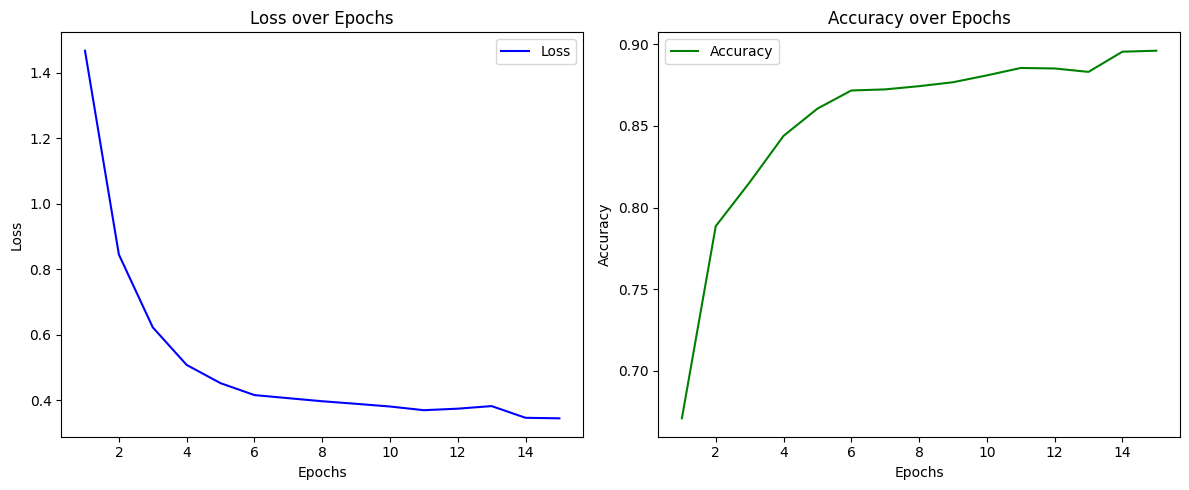

In [ ]:
losses, accuracies = train_n_rounds(15)
plot_loss_accuracy(losses, accuracies)

## Seleccionando clientes con AFL

Vamos a adaptar la configuración del escenario anterior para poder usar nuestro algoritmo AFL en el bucle de entrenamiento. Para esto, debemos de cambiar un poco las funciones que se aplican a los actores.

En primer lugar, creamos la función `client_val` que devuelve la valuación de un cliente y que depende del tamaño de sus datos y de la pérdida de su modelo con sus datos locales.

In [ ]:
import math
from typing import Callable

def client_val(client_model: FlexModel, client_data: Dataset) -> float:
	return client_model["loss"] / math.sqrt(len(client_data))

A continuación definimos la función `train_afl`, que entrena el modelo tal y como se hace en el escenario anterior con RandomSampling, pero esta vez los clientes registran la pérdida de su modelo en entrenamiento.

> Nótese que la pérdida que se guarda es la media de las pérdidas obtenidas en la última época, de manera que la valuación al final del entrenamiento sea la del modelo ya entrenado.

In [ ]:
def train_afl(client_flex_model: FlexModel, client_data: Dataset):
    train_dataset = client_data.to_torchvision_dataset(transform=mnist_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=20)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(5):
        losses = []
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        # get average loss in dataset
        train_loss = sum(losses) / len(losses)

    # save last-epoch training loss
    client_flex_model["loss"] = train_loss

    # compute their valuation
    client_flex_model["val"] = client_val(client_flex_model, client_data)

Para que el agregador/servidor pueda obtener las valuaciones de los clientes, es necesario que declaremos una función `get_clients_vals` que guarde una lista en el agregador de todas las valuaciones de un conjunto de clientes.

In [ ]:
from typing import List

def get_clients_vals(agg_model: FlexModel, clients_flex_models: List[FlexModel]):
    # number of valuations must be exact to the number of clients, we reinitialize the list for that reason
    agg_model["vals"] = []
    for k in clients_flex_models:
        client_val = clients_flex_models[k]["val"]
        agg_model["vals"].append(client_val)

Implementamos entonces la función `client_selection` que implementa el algoritmo de muestreo de clientes AFL [1]. Esta función depende de ciertos parámetros que los pasamos como argumentos en un diccionario `kwargs`.

> [1] https://arxiv.org/abs/1909.12641.

In [ ]:
import math
import numpy as np

def client_selection(agg_model: FlexModel, _agg_data: Dataset, **kwargs):
    K = kwargs["number_of_clients"]
    alpha1 = kwargs["alpha1"]
    alpha2 = kwargs["alpha2"]
    alpha3 = kwargs["alpha3"]
    m = kwargs["clients_per_round"]

	# get valuations by clients
    clients: dict = dict(enumerate(agg_model["vals"]))

	# sort clients by valuation
    sorted_clients = {k: v for k, v in sorted(clients.items(), key=lambda item: item[1])}

	# for the alpha1 * K users with smallest vk, vk = -infinity
    smallest_val = list(sorted_clients.keys())[:math.floor(alpha1 * K)]
    for key in smallest_val:
        sorted_clients[key] = float('-inf')

	# build probability distribution depending on the valuations
    vals = list(sorted_clients.values())

	# get the indexed probability scores
    exp_scores = np.exp(alpha2 * np.array(vals))
    idx = np.array(list(sorted_clients.keys()))
    p = exp_scores / np.sum(exp_scores)

	# sample clients by pk
    Sp_mask = np.argsort(p)[-math.floor(m * (1 - alpha3)):]
    Sp = idx[Sp_mask]

	# sample clients uniformly at random
    remaining = [i for i in idx if i not in Sp]
    Spp = np.random.choice(remaining, size=math.floor(m * alpha3), replace=False)

	# get the union of both S
    return np.union1d(Sp, Spp).tolist()

Necesitamos también inicializar las valuaciones de todos los clientes. Existen distintas formas de inicializar los valores, nosotros optaremos por la opción más justa que es aplicar la función de valuación $\mathcal V$ (`client_val`) en cada cliente usando el modelo inicial del servidor sobre sus propios datos locales. De esta manera, evitamos un sesgo inducido por la aleatoriedad a ciertos clientes en las primeras épocas.

In [ ]:
def init_clients_valuations(client_flex_model: FlexModel, client_data: Dataset):
    """
    Initialize client valuation by predicting their entire data against the server model.
    """
    # convert Dataset to Torchvision dataset
    train_dataset = client_data.to_torchvision_dataset(transform=mnist_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=20)

    model = client_flex_model["model"]
    model.eval()
    train_loss = 0
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    losses = []
    with torch.no_grad():
        for data, target in client_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]

    # compute loss
    train_loss = sum(losses) / len(losses)
    client_flex_model["loss"] = train_loss

    # save initial valuation
    client_flex_model["val"] = client_val(client_flex_model, client_data)

Finalmente, declaramos el _training loop_ usando AFL que realiza los mismo pasos que con RandomSampling pero esta vez:
1. Inicializamos cada cliente con sus valuaciones sobre el modelo inicial del servidor,
2. agregamos una fase en la que el agregador obtiene las valuaciones de _todos_ los clientes para la posterior selección, y
3. finalmente, realizamos la selección de clientes con AFL para la ronda siguiente como última fase.

In [ ]:
ALPHA1 = 0.75
ALPHA2 = 0.01
ALPHA3 = 0.1

def train_n_rounds_afl(n_rounds, clients_per_round=20):
    pool = FlexPool.client_server_pool(
        fed_dataset=flex_dataset, server_id=server_id, init_func=build_server_model
    )

    # initialize valuations to all clients by computing initial model against their data
    print("Initializing clients valuations...")
    pool.servers.map(copy_server_model_to_clients, pool.clients)
    pool.clients.map(init_clients_valuations)

    # get a starter set of selected clients
    pool.aggregators.map(get_clients_vals, pool.clients)
    selected = pool.aggregators.map(
        client_selection,
        pool.clients,
        number_of_clients=len(pool.clients),
        alpha1=ALPHA1,
        alpha2=ALPHA2,
        alpha3=ALPHA3,
        clients_per_round=clients_per_round
    )[0]

    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")

        # take selected clients
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in selected)
        selected_clients = selected_clients_pool.clients

        print(f"Selected clients for this round: {selected}")

        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)

        # Each selected client trains its model
        selected_clients.map(train_afl)

        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)

        # The aggregator collects the valuations of all clients for CS
        pool.aggregators.map(get_clients_vals, pool.clients)

        # The aggregator performs client selection using AFL
        selected = pool.aggregators.map(
            client_selection,
            pool.clients,
            number_of_clients=len(pool.clients),
            alpha1=ALPHA1,
            alpha2=ALPHA2,
            alpha3=ALPHA3,
            clients_per_round=clients_per_round
        )[0]

        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]

        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies

Ejecutamos en primer lugar AFL para $15$ rondas de entrenamiento federado con $20$ clientes por ronda para comparar con el resultado de RandomSampling anterior.

Initializing clients valuations...

Running round: 1 of 15
Selected clients for this round: [932, 934, 1078, 1715, 1878, 1922, 2150, 2198, 2950, 3297, 3474, 3495, 3525, 3551, 3561, 3563, 3564, 3576, 3577, 3578]
Server: Test acc: 0.4364, test loss: 1.6249

Running round: 2 of 15
Selected clients for this round: [932, 934, 975, 1715, 1878, 1922, 2150, 2198, 2657, 2950, 3297, 3474, 3525, 3551, 3561, 3563, 3564, 3576, 3577, 3578]
Server: Test acc: 0.7229, test loss: 0.9569

Running round: 3 of 15
Selected clients for this round: [660, 932, 934, 1058, 1715, 1878, 1922, 2150, 2198, 2950, 3297, 3474, 3525, 3551, 3561, 3563, 3564, 3576, 3577, 3578]
Server: Test acc: 0.7684, test loss: 0.7591

Running round: 4 of 15
Selected clients for this round: [932, 934, 1438, 1715, 1878, 1922, 2150, 2198, 2950, 3297, 3449, 3474, 3525, 3551, 3561, 3563, 3564, 3576, 3577, 3578]
Server: Test acc: 0.7984, test loss: 0.6464

Running round: 5 of 15
Selected clients for this round: [932, 934, 1715, 1878, 1922, 2

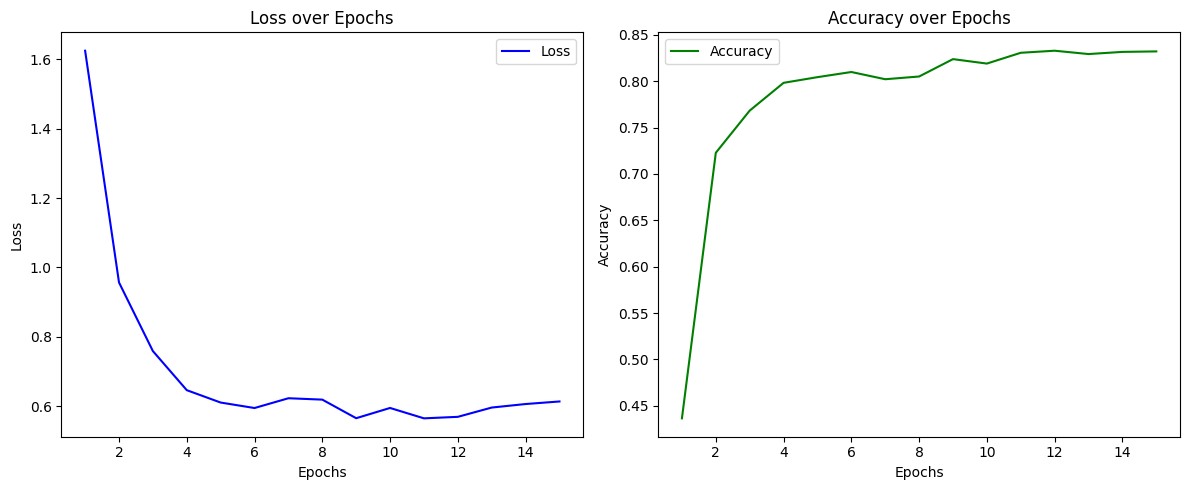

In [ ]:
losses, accuracies = train_n_rounds_afl(15)
plot_loss_accuracy(losses, accuracies)

Podemos observar que el resultado es _peor_ que con RandomSampling tanto en el rendimiento final como en la evolución del aprendizaje con un claro _overfitting_. Este sobreajuste esta fuertemente influenciado en la selección de un conjunto pequeño de "_mejores_" clientes por ronda; si vemos los identificadores de los clientes que se van seleccionando vemos como la mayoría de estos se repiten, por tanto, sobreajusta en los datos de esos clientes _favoritos_. Evidentemente, RandomSampling no tiene este problema al favorecer la aleatoriedad de los clientes por ronda, mejorando a AFL en este escenario.

Los autores en [1] expresan que usaron $200$ clientes por ronda en vez de $20$ sobre dos datasets distintos al que estamos utilizando en este pero que realizaron los experimentos sobre datos no-IID. El aumento de estos clientes por ronda puede sanitizar el excesivo sobreajuste al considerar más datos de clientes distintos por ronda. Aún tenemos el sesgo sobre clientes _favoritos_, pero con el aumento de clientes por ronda podemos hacer que el número de clientes seleccionados aleatoriamente crezca y subsane el overfitting.

Realizaremos el mismo experimento pero con $m = 200$ clientes por ronda tanto para AFL como para RandomSampling de manera que la comparación sea justa.

> [1] https://arxiv.org/abs/1909.12641.


Running round: 1 of 15
Selected clients for this round: 200
Server: Test acc: 0.6009, test loss: 1.5650

Running round: 2 of 15
Selected clients for this round: 200
Server: Test acc: 0.7944, test loss: 0.8922

Running round: 3 of 15
Selected clients for this round: 200
Server: Test acc: 0.8308, test loss: 0.6353

Running round: 4 of 15
Selected clients for this round: 200
Server: Test acc: 0.8459, test loss: 0.5258

Running round: 5 of 15
Selected clients for this round: 200
Server: Test acc: 0.8590, test loss: 0.4612

Running round: 6 of 15
Selected clients for this round: 200
Server: Test acc: 0.8657, test loss: 0.4274

Running round: 7 of 15
Selected clients for this round: 200
Server: Test acc: 0.8697, test loss: 0.4091

Running round: 8 of 15
Selected clients for this round: 200
Server: Test acc: 0.8741, test loss: 0.3951

Running round: 9 of 15
Selected clients for this round: 200
Server: Test acc: 0.8792, test loss: 0.3803

Running round: 10 of 15
Selected clients for this roun

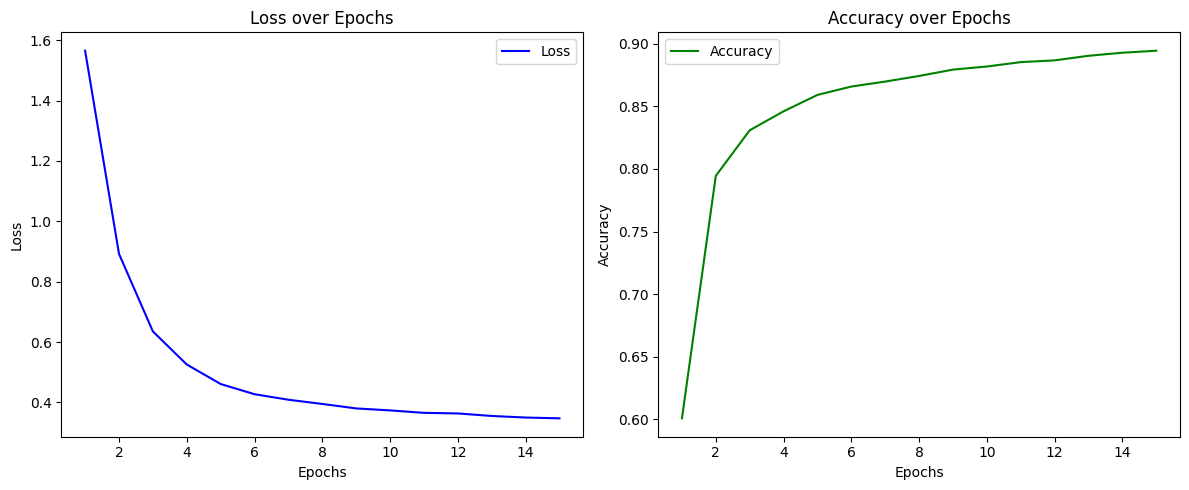

In [ ]:
losses, accuracies = train_n_rounds(15, 200)
plot_loss_accuracy(losses, accuracies)

Initializing clients valuations...

Running round: 1 of 15
Selected clients for this round: [50, 55, 70, 87, 107, 127, 136, 168, 200, 207, 240, 341, 349, 386, 394, 403, 446, 450, 478, 512, 547, 625, 660, 684, 731, 760, 796, 842, 850, 873, 878, 929, 932, 934, 1001, 1019, 1034, 1036, 1053, 1087, 1089, 1095, 1100, 1131, 1154, 1157, 1177, 1201, 1237, 1255, 1329, 1331, 1359, 1421, 1460, 1485, 1504, 1530, 1550, 1567, 1572, 1601, 1629, 1655, 1675, 1698, 1715, 1717, 1727, 1728, 1737, 1745, 1748, 1755, 1767, 1773, 1776, 1778, 1802, 1866, 1873, 1878, 1888, 1892, 1903, 1904, 1906, 1909, 1919, 1922, 1982, 1994, 2022, 2053, 2075, 2083, 2150, 2158, 2182, 2198, 2230, 2251, 2258, 2289, 2344, 2403, 2424, 2445, 2451, 2453, 2454, 2462, 2466, 2472, 2502, 2507, 2522, 2549, 2579, 2610, 2634, 2641, 2664, 2680, 2728, 2772, 2785, 2843, 2854, 2915, 2941, 2950, 3006, 3019, 3042, 3077, 3085, 3092, 3131, 3133, 3149, 3196, 3203, 3204, 3214, 3222, 3247, 3263, 3270, 3271, 3276, 3277, 3280, 3282, 3289, 3295, 3296, 329

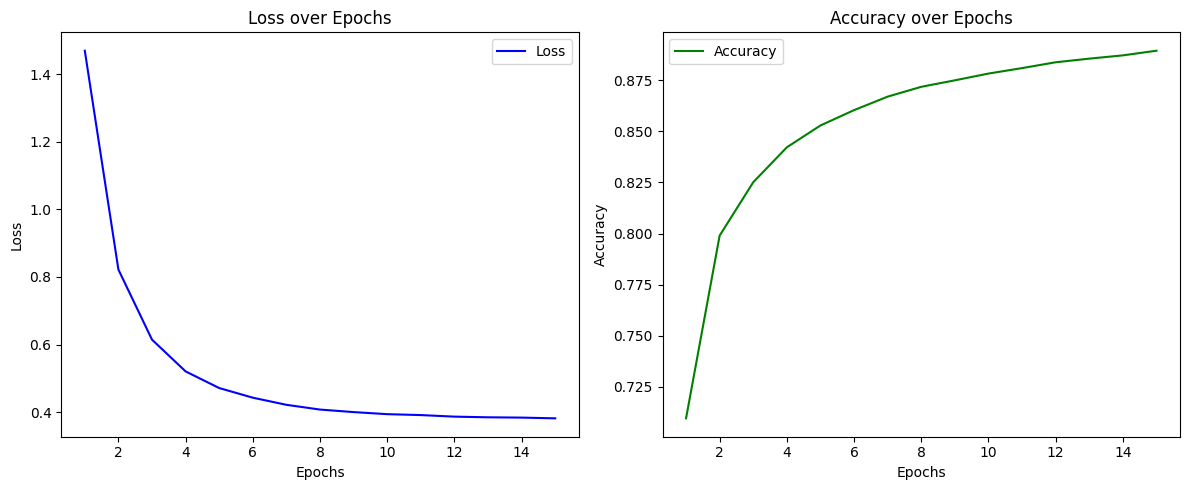

In [ ]:
losses, accuracies = train_n_rounds_afl(15, 200)
plot_loss_accuracy(losses, accuracies)

Vemos como en AFL el rendimiento a mejorado considerablemente, acercándose al de RandomSampling pero aún siendo peor que este. Además, la supuesta rápida convergencia en AFL tampoco se ve reflejada en el entrenamiento, de hecho, es muy similar o incluso un poco más lenta que con RandomSampling. El hecho es que hemos aumentado el número de clientes a considerar por ronda, mejorando el rendimiento en cuanto a que se seleccionan más clientes de forma aleatoria, imitando el comportamiento de RandomSampling. Podemos probar promover esta selección más aleatoria usando un $\alpha_3$ más alto, es decir, aumentar el número de clientes seleccionados aleatoriamente (por ejemplo, aumentarlo a un $40\%$ y el resto será por su probabilidad basada en valuación $p_k$).

Initializing clients valuations...

Running round: 1 of 15
Selected clients for this round: [7, 12, 50, 52, 63, 78, 83, 87, 127, 130, 155, 157, 168, 185, 196, 202, 207, 240, 261, 334, 341, 344, 349, 430, 446, 450, 452, 467, 478, 548, 578, 612, 658, 741, 760, 782, 836, 842, 850, 861, 873, 932, 934, 969, 984, 1001, 1019, 1056, 1100, 1101, 1154, 1184, 1201, 1209, 1318, 1328, 1421, 1434, 1459, 1460, 1468, 1485, 1530, 1593, 1628, 1629, 1632, 1655, 1667, 1675, 1694, 1715, 1727, 1728, 1748, 1803, 1806, 1817, 1823, 1866, 1878, 1883, 1903, 1909, 1922, 1923, 1932, 1961, 1982, 1992, 1994, 2024, 2052, 2053, 2075, 2150, 2158, 2182, 2198, 2216, 2251, 2258, 2269, 2278, 2289, 2326, 2398, 2402, 2445, 2451, 2453, 2462, 2466, 2472, 2502, 2546, 2549, 2562, 2579, 2610, 2623, 2634, 2638, 2641, 2642, 2668, 2675, 2728, 2741, 2765, 2772, 2785, 2813, 2837, 2839, 2843, 2845, 2915, 2925, 2950, 3040, 3042, 3058, 3074, 3077, 3085, 3092, 3131, 3133, 3134, 3196, 3204, 3222, 3263, 3270, 3276, 3277, 3280, 3282, 3284, 3

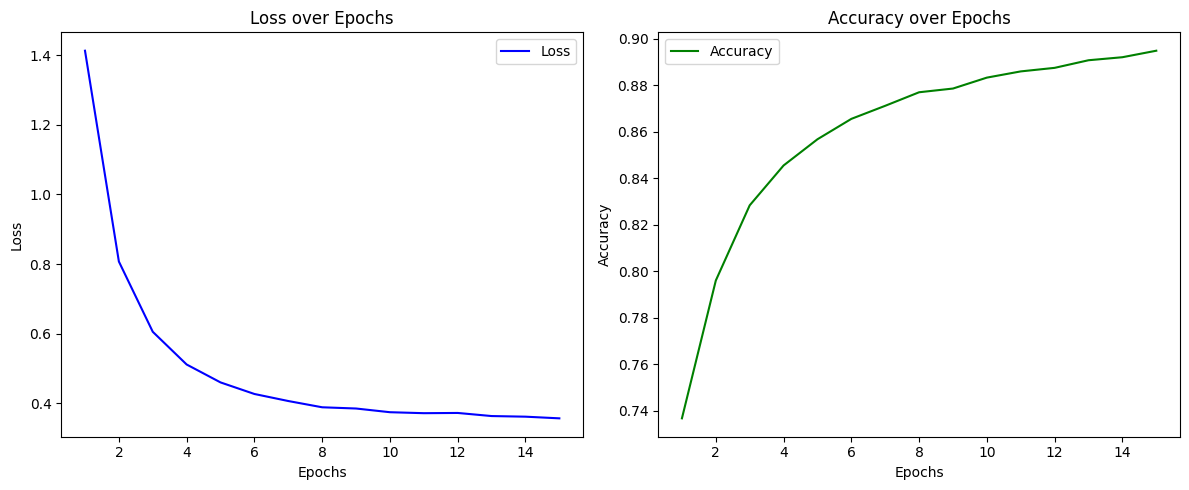

In [ ]:
ALPHA3 = 0.4
losses, accuracies = train_n_rounds_afl(15, 200)
plot_loss_accuracy(losses, accuracies)

Podemos ver que en efecto, el rendimiento mejora gracias a que estamos induciendo un índice de aleatoriedad en la selección de los clientes, logrando un rendimiento muy similar a RandomSampling con unas curvas de aprendizaje mucho más suavizadas que dan indicios de sanitizar el sobreajuste. Sin embargo, RandomSampling presenta una ligera velocidad de convergencia mayor a AFL.